# Imports


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten,BatchNormalization, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import cv2
import shutil
import random
import matplotlib.pyplot as plt
import warnings
import glob
import joblib
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
from keras.layers import GlobalAveragePooling2D
from keras.layers import MaxPool2D
from keras.layers import Convolution2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.applications import VGG16

## Functions

In [2]:
def detect_face(image_path):
    # Laden des Gesichtserkennungs-Klassifikators (Haar-Cascade)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    # Laden des Bildes
    image = cv2.imread(image_path)
    if image is not None:
        # Konvertieren des Bildes in Graustufen
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Gesichter im Bild erkennen
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(200, 200))
        if len(faces) > 0:
            # Nehme das erste erkannte Gesicht
            (x, y, w, h) = faces[0]
            # Schneide das Gesicht aus
            face = image[y:y+h, x:x+w]
             # Zeichne ein Rechteck um das erkannte Gesicht
            ##cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
            return face
        else:
            print(f"No face detected in {image_path}")
            return None
    else:
        print(f"Failed to load image: {image_path}")
        return None

# Organize data into train and test dirs

In [3]:
# Ordnerstruktur erstellen und Bilder kopieren
def create_dataset_with_face_detection(src_dir, dest_dir):
    # Erstellen der Ordnerstruktur
    for class_name in ['nino', 'robin']:
        for dataset_type in ['train', 'valid', 'test']:
            os.makedirs(os.path.join(dest_dir, dataset_type, class_name), exist_ok=True)

    # Kopieren der Bilder mit Gesichtserkennung
    for class_name in ['nino', 'robin']:
        image_files = glob.glob(os.path.join(src_dir, class_name, '*'))
        for dataset_type in ['train', 'valid', 'test']:
            if dataset_type == 'train':
                num_images_to_copy = 14
            elif dataset_type == 'valid':
                num_images_to_copy = 6
            else:
                num_images_to_copy = 4
                
            selected_images = random.sample(image_files, num_images_to_copy)
            for image_path in selected_images:
                face = detect_face(image_path)
                if face is not None:
                    dest_path = os.path.join(dest_dir, dataset_type, class_name, os.path.basename(image_path))
                    cv2.imwrite(dest_path, face)
                    print(f"Saved {dest_path}")

# Pfad zum Quellverzeichnis der Bilder
src_dir = 'archive'

# Pfad zum Zielverzeichnis der Trainings-, Validierungs- und Testbilder
dest_dir = 'face_dataset'

# Erstellen der Datensätze mit Gesichtserkennung
create_dataset_with_face_detection(src_dir, dest_dir)

Saved face_dataset\train\nino\20240403_185047.jpg
Saved face_dataset\train\nino\20240403_185511.jpg
Saved face_dataset\train\nino\20240403_185217.jpg
Saved face_dataset\train\nino\20240403_185526.jpg
Saved face_dataset\train\nino\image (2).jpg
Saved face_dataset\train\nino\image (4).jpg
Saved face_dataset\train\nino\20240403_1851150.jpg
Saved face_dataset\train\nino\image (1).jpg
Saved face_dataset\train\nino\20240403_185222.jpg
Saved face_dataset\train\nino\image (3).jpg
Saved face_dataset\train\nino\20240403_185056.jpg
Saved face_dataset\train\nino\20240403_185045.jpg
Saved face_dataset\train\nino\20240403_185543.jpg
Saved face_dataset\train\nino\20240403_185237.jpg
Saved face_dataset\valid\nino\image (1).jpg
Saved face_dataset\valid\nino\image (4).jpg
Saved face_dataset\valid\nino\20240403_185222.jpg
Saved face_dataset\valid\nino\20240403_185056.jpg
Saved face_dataset\valid\nino\20240403_185045.jpg
Saved face_dataset\valid\nino\20240403_185115.jpg
Saved face_dataset\test\nino\202404

In [4]:
os.chdir('face_dataset')
if os.path.isdir('train/nino') is False:
    os.makedirs('train/nino')
    os.makedirs('train/robin')
    os.makedirs('valid/nino')
    os.makedirs('valid/robin')
    os.makedirs('test/nino')
    os.makedirs('test/robin')
    
    for c in random.sample(glob.glob('robin/*'), 16):
        shutil.copy(c, 'train/robin/' + os.path.basename(c))
    for c in random.sample(glob.glob('nino/*'), 16):
        shutil.copy(c, 'train/nino/' + os.path.basename(c))
    for c in random.sample(glob.glob('robin/*'), 4):
        shutil.copy(c, 'valid/robin/'+ os.path.basename(c))
    for c in random.sample(glob.glob('nino/*'), 4):
        shutil.copy(c, 'valid/nino/'+ os.path.basename(c))
    for c in random.sample(glob.glob('robin/*'), 4):
        shutil.copy(c, 'test/robin/'+ os.path.basename(c))
    for c in random.sample(glob.glob('nino/*'), 4):
        shutil.copy(c, 'test/nino/'+ os.path.basename(c))

In [5]:
train_path = 'E:/ZHAW/Semester4/Project/face-recognition/face_dataset/train'
valid_path = 'E:/ZHAW/Semester4/Project/face-recognition/face_dataset/valid'
test_path = 'E:/ZHAW/Semester4/Project/face-recognition/face_dataset/test'

In [6]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['robin', 'nino'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['robin', 'nino'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['robin', 'nino'], batch_size=10, shuffle=False)
    

Found 28 images belonging to 2 classes.
Found 12 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


Trainingsbilder:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


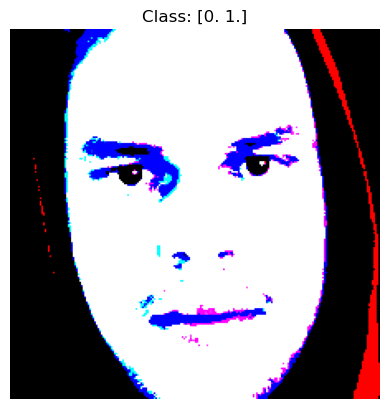

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


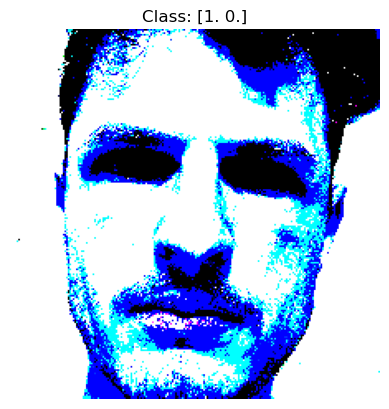

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


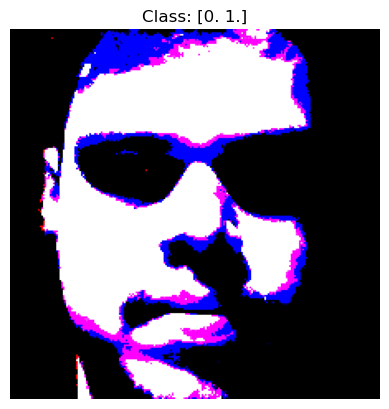

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


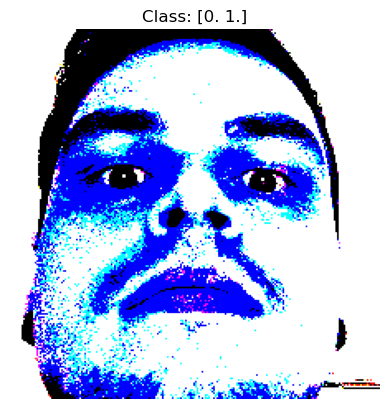

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


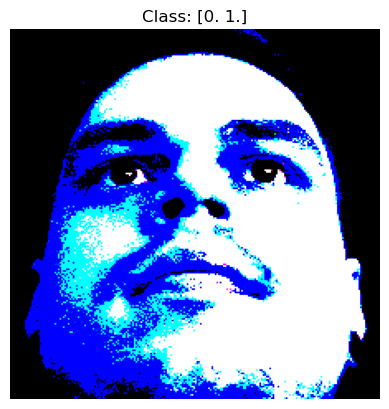

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Validierungsbilder:


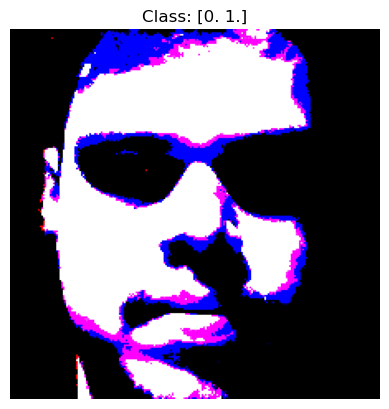

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


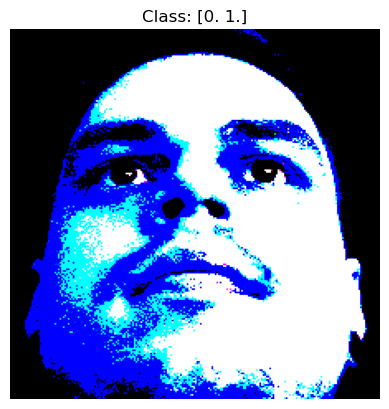

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


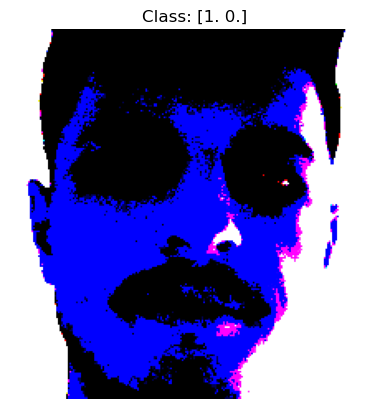

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


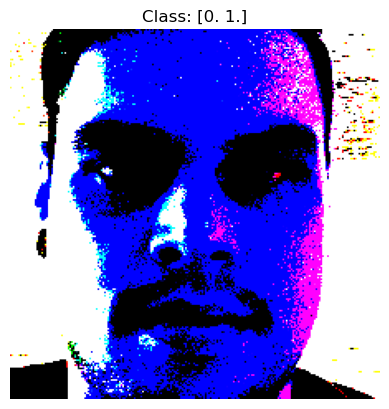

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


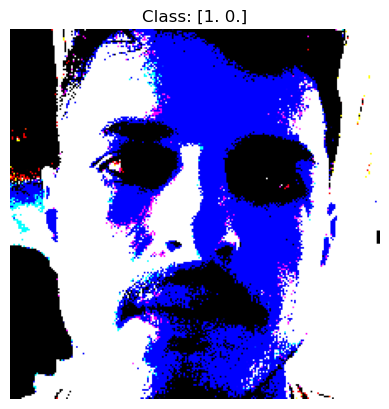

Testbilder:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


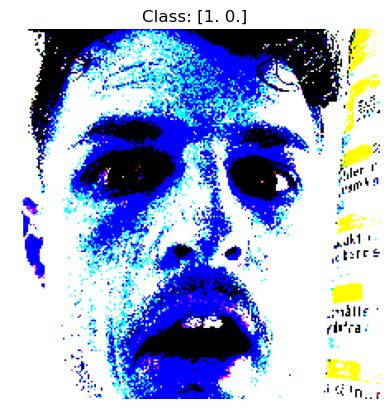

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


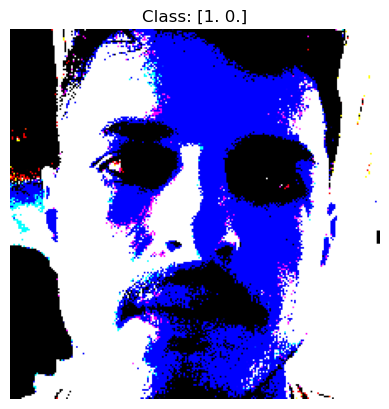

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


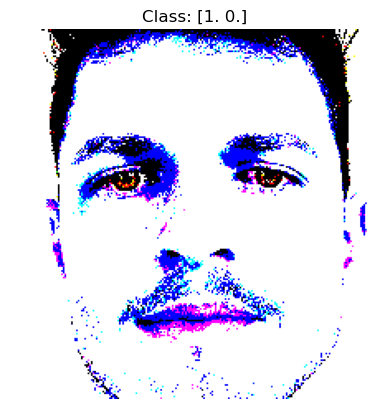

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


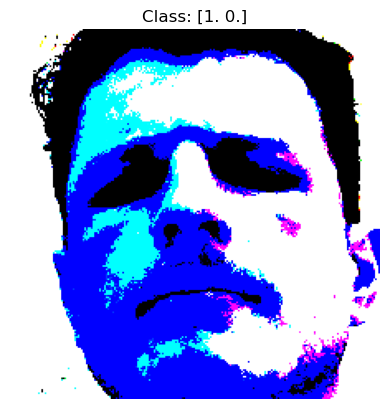

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


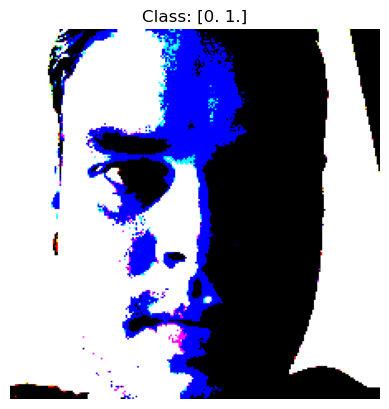

In [7]:
# Funktion zum Plotten von Bildern aus einem Bildgenerator
def plot_images(generator, num_images=5):
    # Lade eine Batch von Bildern
    images, labels = next(generator)
    
    # Plotte die ersten num_images Bilder
    for i in range(num_images):
        plt.imshow(images[i])
        plt.title(f"Class: {labels[i]}")
        plt.axis('off')
        plt.show()

# Plotte Bilder aus dem Trainingsbatch
print("Trainingsbilder:")
plot_images(train_batches)

# Plotte Bilder aus dem Validierungsbatch
print("Validierungsbilder:")
plot_images(valid_batches)

# Plotte Bilder aus dem Testbatch
print("Testbilder:")
plot_images(test_batches)

In [8]:
imgs, labels = next(train_batches)

# Plot Images

In [9]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

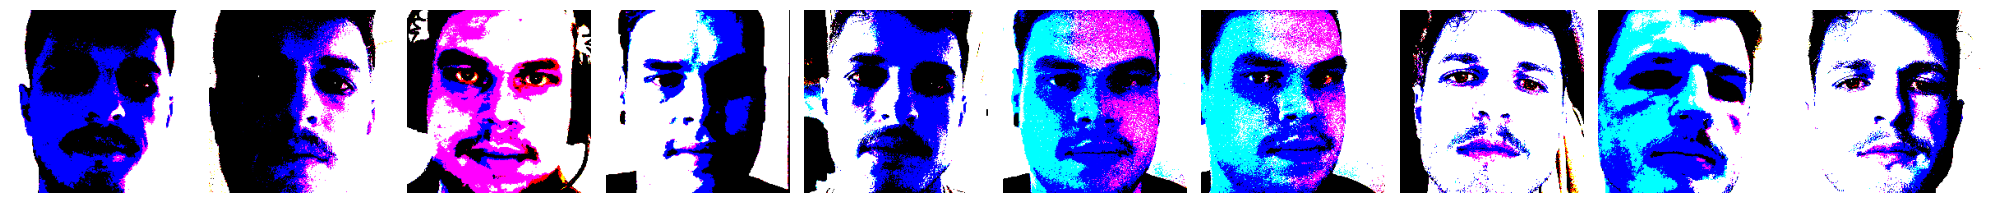

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [10]:
plotImages(imgs)
print(labels)

# Build and train CNN

In [ ]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='sigmoid'),
])

In [ ]:
model = Sequential([
    # Convolutional Layer 1
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Convolutional Layer 2
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Convolutional Layer 3
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Flattening Layer
    Flatten(),
    
    # Fully Connected Layer
    Dense(units=512, activation='relu'),
    
    # Dropout Layer to reduce overfitting
    Dropout(0.5),
    
    # Output Layer
    Dense(units=2, activation='sigmoid')
    ])

## VGG Model

In [11]:
# Erstellen eines Sequential-Modells
model = Sequential()

# Hinzufügen des VGG16-Modells
model.add(VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))

# Einfrieren der Gewichte des VGG16-Modells, um sie während des Trainings nicht zu aktualisieren
model.layers[0].trainable = False

# Hinzufügen der weiteren Schichten
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))  # Annahme von 2 Klassen

Epoch 1/5
3/3 - 6s - loss: 3.8981 - accuracy: 0.7143 - val_loss: 11.6805 - val_accuracy: 0.7500 - 6s/epoch - 2s/step
Epoch 2/5
3/3 - 5s - loss: 7.0114 - accuracy: 0.7857 - val_loss: 10.6299 - val_accuracy: 0.6667 - 5s/epoch - 2s/step
Epoch 3/5
3/3 - 5s - loss: 3.2781 - accuracy: 0.8571 - val_loss: 5.8611e-07 - val_accuracy: 1.0000 - 5s/epoch - 2s/step
Epoch 4/5
3/3 - 5s - loss: 1.3516 - accuracy: 0.9643 - val_loss: 0.9240 - val_accuracy: 0.9167 - 5s/epoch - 2s/step
Epoch 5/5
3/3 - 4s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.2972 - val_accuracy: 0.9167 - 4s/epoch - 1s/step


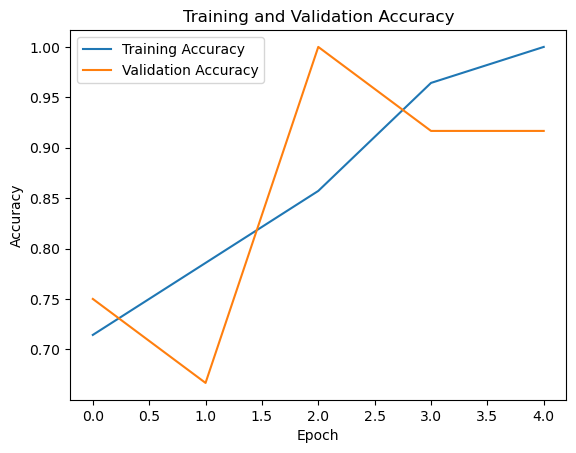

In [12]:
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
history = model.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)

test_imgs, test_labels = next(test_batches)

test_batches.classes

predictions = model.predict(x=test_batches, verbose=0)

np.round(predictions)

# Plot the learning curve
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Speichern des Modells
model.save("E:/ZHAW/Semester4/Project/face-recognition/mein_keras_modell.h5")

In [13]:
# Festlegen der Anzahl der anzuzeigenden Bilder
num_images_to_display = 8

# Ausgabe der Vorhersagen und Zuversicht für die ersten num_images_to_display Bilder
for i in range(num_images_to_display):
    # Index des aktuellen Bilds
    img_index = i
    
    # Vorhersagen für das aktuelle Bild
    prediction = predictions[img_index]
    
    # Tatsächliche Klasse des aktuellen Bilds
    actual_class = "robin" if test_labels[img_index][0] == 1 else "nino"
    
    # Vorhergesagte Klasse des aktuellen Bilds
    predicted_class = "robin" if prediction[0] >= 0.5 else "nino"
    
    # Zuversicht (Sicherheit) der Vorhersage für die vorhergesagte Klasse
    confidence = prediction[0] if predicted_class == "robin" else 1 - prediction[0]
    
    # Ausgabe der Vorhersage und Zuversicht
    print(f"Image {img_index + 1}: Actual Class = {actual_class}, Predicted Class = {predicted_class}, Confidence = {confidence:.2f}")

Image 1: Actual Class = robin, Predicted Class = robin, Confidence = 1.00
Image 2: Actual Class = robin, Predicted Class = robin, Confidence = 1.00
Image 3: Actual Class = robin, Predicted Class = robin, Confidence = 1.00
Image 4: Actual Class = robin, Predicted Class = robin, Confidence = 1.00
Image 5: Actual Class = nino, Predicted Class = nino, Confidence = 1.00
Image 6: Actual Class = nino, Predicted Class = nino, Confidence = 1.00
Image 7: Actual Class = nino, Predicted Class = nino, Confidence = 1.00
Image 8: Actual Class = nino, Predicted Class = nino, Confidence = 1.00


Confusion matrix, without normalization
[[4 0]
 [0 4]]


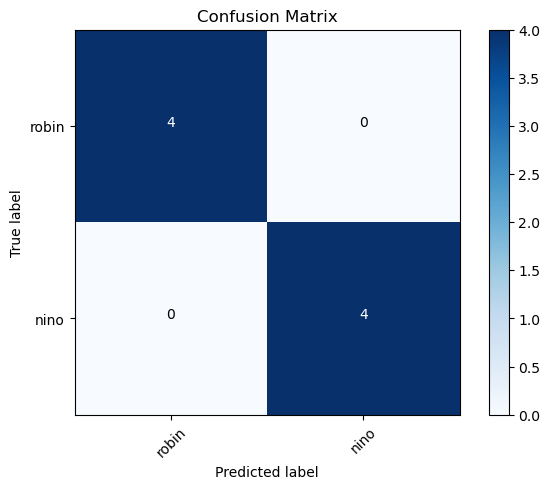

In [14]:

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
    
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')
    
        print(cm)
    
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

cm_plot_labels = ['robin','nino']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
